<a href="https://colab.research.google.com/github/Sharonio/VideoThat/blob/master/click_analysis/comparing_manually_detected_codas_with_UMAP_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing manually detected codas with the UMAP clusters
The porpuse of this notebook is simple: we have 2 type of references to the data:

1.   Manaully detected Codas
2.   Auto detected clicks and their assigned cluster

Our goal: to examine the codas, find their corresponding clicks (if those exist), and answer the following questions:

1.   How many of the manually tagged coda-clicks were detected in %?
2.   In which of the clusters can we find them?
3.   Output a pkl file of auto + manual clicks for further analysis 

Why are we doing this? in the data we have a lot of redundancy, we want to varify some of the clusters are echo-location related, through them away and create a dataset of mostly communication clicks. This will help us to further analyse them.


In [0]:
%%capture
!pip install soundfile hdbscan umap-learn pandas librosa numpy tqdm

In [0]:
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import hdbscan
from pathlib import Path
from tqdm import tqdm
import random
import umap
np.random.seed(42)

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# The path to the dataset on the shared Google Drive
dataset_path = Path('/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
file_name = str(dataset_path) + '/allCodas20191128.pkl'
loaded_df = pd.read_pickle(file_name)
loaded_df.head(3)

codaNUM2018  ...                                           wav_file
0         4931  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1         4932  ...  /content/drive/Shared drives/Dominica Sperm Wh...
2         4933  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[3 rows x 101 columns]

In [5]:
loaded_df.shape

(3535, 101)

In [6]:
loaded_df.columns.values

array(['codaNUM2018', 'REC', 'nClicks', 'Duration', 'ICI1', 'ICI2',
       'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'ICI10',
       'ICI11', 'ICI12', 'ICI13', 'ICI14', 'ICI15', 'ICI16', 'ICI17',
       'ICI18', 'ICI19', 'ICI20', 'ICI21', 'ICI22', 'ICI23', 'ICI24',
       'ICI25', 'ICI26', 'ICI27', 'ICI28', 'ICI29', 'ICI30', 'ICI31',
       'ICI32', 'ICI33', 'ICI34', 'ICI35', 'ICI36', 'ICI37', 'ICI38',
       'ICI39', 'ICI40', 'ELKI2', 'ELKI2name', 'Unit', 'UnitNum', 'IDN',
       'Date', 'TagOnTime', 'Name', 'Bout', 'Whale', 'Coda', 'TsTo',
       'Tag', 'Focal', 'IPI1', 'IPI2', 'IPI3', 'IPI4', 'IPI5', 'IPI6',
       'IPI7', 'IPI8', 'IPI9', 'IPI10', 'IPI11', 'IPI12', 'IPI13',
       'IPI14', 'IPI15', 'IPI16', 'IPI17', 'IPI18', 'IPI19', 'IPI20',
       'IPI21', 'IPI22', 'IPI23', 'IPI24', 'IPI25', 'IPI26', 'IPI27',
       'IPI28', 'IPI29', 'IPI30', 'IPI31', 'IPI32', 'IPI33', 'IPI34',
       'IPI35', 'IPI36', 'IPI37', 'IPI38', 'IPI39', 'IPI40', 'start_time',
       'start_f

In [7]:
loaded_df.REC.value_counts()

sw061b00           839
sw061b002_14375    108
sw085a002_9376      79
sw078a001_3209      63
sw100b001_18335     55
                  ... 
sw134a001_372        1
sw103a002_10818      1
sw103a001_4482       1
sw061b002_13952      1
sw133a004_19644      1
Name: REC, Length: 197, dtype: int64

In [8]:
manual_df = loaded_df[loaded_df["REC"].str.contains("sw061", na=False)]
print(manual_df.shape)
manual_df.head(3)


(1272, 101)


codaNUM2018  ...                                           wav_file
0         4931  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1         4932  ...  /content/drive/Shared drives/Dominica Sperm Wh...
2         4933  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[3 rows x 101 columns]

In [9]:
manual_df.REC.value_counts()

sw061b00           839
sw061b002_14375    108
sw061b001_124       54
sw061b001_3872      45
sw061b002_13766     37
sw061b001_7071      33
sw061b001_7223      31
sw061b002_11093     31
sw061b001_513       27
sw061b001_4333      18
sw061b002_13901     15
sw061b002_13975      7
sw061b002_7968       7
sw061b001_629        6
sw061b002_11205      4
sw061b001_4421       3
sw061b002_8135       2
sw061b002_11267      2
sw061b002_13952      1
sw061b001_4461       1
sw061b001_6945       1
Name: REC, dtype: int64

In [10]:

manual_df.start_file.value_counts()

/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b003.wav    725
/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b002.wav    288
/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b001.wav    219
/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b004.wav     40
Name: start_file, dtype: int64

In [11]:
manual_sw061b003 = manual_df[manual_df.start_file == '/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b003.wav']
manual_sw061b003.tail(5)

codaNUM2018  ...                                           wav_file
1227         6158  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1228         6159  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1229         6160  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1230         6161  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1231         6162  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[5 rows x 101 columns]

In [20]:
manual_click_offsets = manual_sw061b003[manual_sw061b003.columns[manual_sw061b003.columns.str.startswith('ICI')]]
# relative to absolute offsets - from delta between clicks to time from start of coda
full_offsets = manual_click_offsets.cumsum(1)
# now, global time
# (sorry for numpy hack - pandas didn't do the right broadcasting:
#  full_offsets += manual_df.start_time did not add the start time of each row to the rest of the row)
full_offsets += manual_df.start_time.values[:,np.newaxis]
# add start_time column
full_offsets.insert(0, 'start_time', value=manual_sw061b003.start_time)
full_offsets.tail()

ValueError: ignored

In [21]:
# we have 40 columns and codas are usually 3-7 clicks long
# Time to mark click columns after the last click in each coda to be NaN

# we will create a matrix of [num codas x 40]
# which will store each click's index in the cell
# e.g.
# 0 1 2 3 4 5 6 ...
# 0 1 2 3 4 5 6 ...
# 0 1 2 3 4 5 6 ...
# ...
#
# then ask for each row if the cells in the row are less than coda length for
# the coda the row represents
# this can be broadcast efficiently using numpy magic
click_index = np.repeat(np.arange(full_offsets.shape[1])[np.newaxis], full_offsets.shape[0], axis=0)
is_valid_click = click_index < manual_df.nClicks.values[:,np.newaxis]
full_offsets[~is_valid_click] = np.NaN
#np.ones_like(full_offsets).cumsum(axis=1) 
full_offsets.tail()

ValueError: ignored

In [0]:
# full_offsets.shape

# Here we have all the clicks. Please delete me.

In [23]:
# all the clicks 
all_clicks = full_offsets.reset_index().rename(columns={'index': 'coda_index'}).melt('coda_index').dropna()
all_clicks.head()

coda_index variable     value
0         507     ICI1  0.112483
1         508     ICI1  0.247742
2         509     ICI1  0.238225
3         510     ICI1  0.243092
4         511     ICI1  0.234617

In [24]:
manual_sw061b003.nClicks.sum(), all_clicks.shape

(3957, (29000, 3))

In [25]:
file_name = str(dataset_path) + '/auto_detected_clicks/extracted_features/sw061b_clustered.pkl'
auto_df = pd.read_pickle(file_name)
print(auto_df.shape)

(40430, 9)


In [26]:
auto_df.head(3)

onset_location_frame  ...       time
0               1199104  ...   9.992533
1               1564160  ...  13.034667
2               1743872  ...  14.532267

[3 rows x 9 columns]

In [27]:
auto_sw061b003 = auto_df[auto_df.path == '/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b003.wav']
print(auto_sw061b003.shape)

(10532, 9)


In [28]:
auto_sw061b003.head(3)

onset_location_frame  ...     time
20505                803328  ...   6.6944
20506               1411584  ...  11.7632
20507               1416192  ...  11.8016

[3 rows x 9 columns]

In [29]:
manual_sw061b003.head(3)

codaNUM2018  ...                                           wav_file
507         5438  ...  /content/drive/Shared drives/Dominica Sperm Wh...
508         5439  ...  /content/drive/Shared drives/Dominica Sperm Wh...
509         5440  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[3 rows x 101 columns]

In [0]:
# Take the row corresponding to the file sw061b003.wav
wav_path = '/content/drive/Shared drives/Dominica Sperm Whale/Dominica Sperm Whale Data/2015/sw061b003.wav'
#str(dataset_path) + '/2015/sw061b003.wav'

# how many samples in the wav in a minute of sound
minute = auto_df.samplerate[0] * 60

# starting point is at the beginning of the file
# (commented out is 80 minutes into the recording)
start_time_second = 560
start_frame = start_time_second*auto_df.samplerate[0] #80 * minute
# load the actal data - load 5 minutes of audio starting at start_frame
data, samplerate = sf.read(wav_path, minute*5, start_frame)

In [31]:
# stereo -> mono by averaging left and right
x = 0.5 * (data[:,0] + data[:,1])

# play the first 15 seconds of the file to see that things are working right
ipd.Audio(x[:samplerate * 15], rate=samplerate)

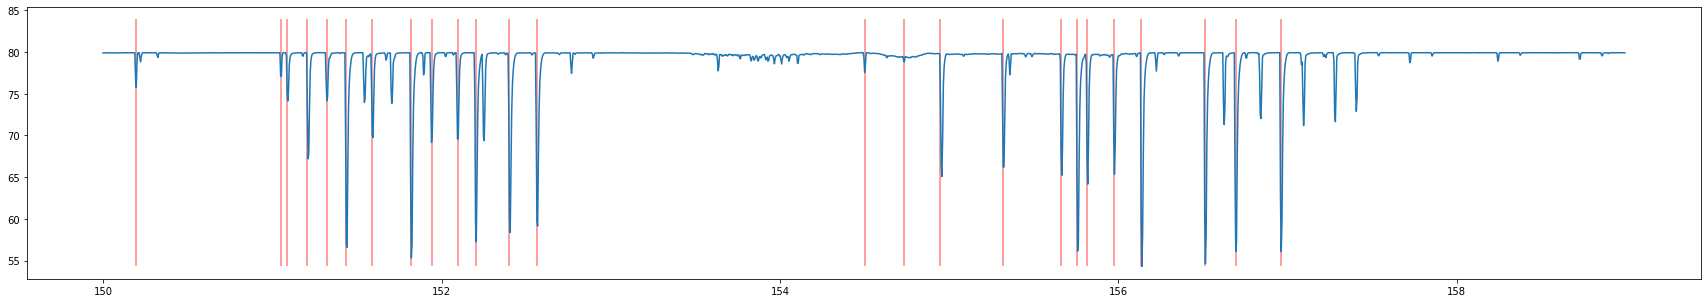

In [32]:
hop_length = 512
frame_length = samplerate/hop_length

D = np.abs(librosa.stft(x, hop_length=hop_length)) # spectrogram
times = librosa.times_like(D, sr=samplerate)
#rms = librosa.feature.rms(S=D)[0] # look for peaks in the RMS graph
rms_logarithmic = librosa.feature.rms(S=librosa.amplitude_to_db(D, ref=np.max))[0]

plt.figure(figsize=(30,5))
# let's look at a range of seconds

start_second = 150
end_second = 159

start_frame = librosa.time_to_frames(start_second, sr=samplerate, hop_length=hop_length)
end_frame = librosa.time_to_frames(end_second, sr=samplerate, hop_length=hop_length)
start_sample = librosa.time_to_samples(start_second, sr=samplerate)
end_sample = librosa.time_to_samples(end_second, sr=samplerate)


auto_onsets_to_show = auto_sw061b003[(auto_sw061b003.onset_location_frame >= (start_sample + start_time_second*samplerate)) 
                                   & (auto_sw061b003.onset_location_frame < (end_sample + start_time_second*samplerate))]

# convert samples->time
auto_onsets_to_show = librosa.samples_to_frames(auto_onsets_to_show.onset_location_frame.values - start_time_second*samplerate, hop_length=hop_length)

plt.vlines(times[auto_onsets_to_show],
           rms_logarithmic[start_frame:end_frame].min(),
           rms_logarithmic[start_frame:end_frame].max()*1.05,
           color='r',
           alpha=0.5,
           linestyle='-',
           label='Onsets')

manual_clicks = all_clicks[(all_clicks.value >= (start_second + start_time_second)) & (all_clicks.value < (end_second + start_time_second))]
plt.vlines(manual_clicks.value - start_time_second,
           rms_logarithmic[start_frame:end_frame].min(),
           rms_logarithmic[start_frame:end_frame].max()*1.05,
           color='g',
           alpha=0.75,
           linestyle='--',
           label='Onsets')

plt.plot(times[start_frame:end_frame], rms_logarithmic[start_frame:end_frame], label='Onset strength')

In [33]:
ipd.Audio(x[start_frame * 512 : end_frame * 512], rate=samplerate)

# Now we'll create a merged click table with both manual and auto clicks

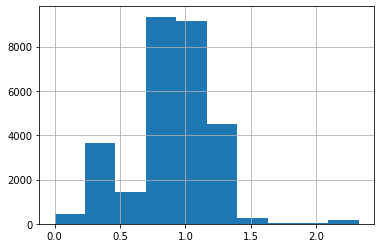

In [34]:
all_clicks.value.hist()

In [35]:
# set cluster to NaN for manually tagged clicks
all_clicks = all_clicks.assign(cluster=np.nan).reset_index(drop=True)
all_clicks.head()

coda_index variable     value  cluster
0         507     ICI1  0.112483      NaN
1         508     ICI1  0.247742      NaN
2         509     ICI1  0.238225      NaN
3         510     ICI1  0.243092      NaN
4         511     ICI1  0.234617      NaN

In [36]:
auto_sw061b003.head()

onset_location_frame  ...       time
20505                803328  ...   6.694400
20506               1411584  ...  11.763200
20507               1416192  ...  11.801600
20508               1656320  ...  13.802667
20509               1666048  ...  13.883733

[5 rows x 9 columns]

In [37]:
all_clicks = all_clicks[['value','cluster']].rename(columns={'value': 'time'})
all_clicks.head(2)

time  cluster
0  0.112483      NaN
1  0.247742      NaN

In [0]:
mega_clicks = pd.concat([auto_sw061b003[['time', 'cluster', 'onset_data_window']], all_clicks], sort=False).reset_index(drop=True)
#.sort_values('time')

In [39]:
# all click times, NaN for all automatic clicks
print(mega_clicks.shape)
mega_clicks.head()

(39532, 3)


time  cluster                                  onset_data_window
0   6.694400     11.0  [-0.0594635009765625, -0.0594635009765625, -0....
1  11.763200     11.0  [-0.0595703125, -0.0595703125, -0.0595703125, ...
2  11.801600     11.0  [-0.06085205078125, -0.06085205078125, -0.0608...
3  13.802667     11.0  [-0.0600738525390625, -0.060089111328125, -0.0...
4  13.883733     11.0  [-0.060211181640625, -0.060272216796875, -0.06...

In [0]:
# calculate time from last click and time to next click
mega_clicks = mega_clicks.assign(delta_t_prev = mega_clicks.time.diff(), delta_t_next = -mega_clicks.time.diff(-1))

In [41]:
mega_clicks.head()


time  cluster  ... delta_t_prev  delta_t_next
0   6.694400     11.0  ...          NaN      5.068800
1  11.763200     11.0  ...     5.068800      0.038400
2  11.801600     11.0  ...     0.038400      2.001067
3  13.802667     11.0  ...     2.001067      0.081067
4  13.883733     11.0  ...     0.081067      2.193067

[5 rows x 5 columns]

In [42]:
manual_enriched_clicks = mega_clicks[mega_clicks.cluster.isnull()]
(manual_enriched_clicks.delta_t_prev < manual_enriched_clicks.delta_t_next).value_counts()

True     14932
False    14068
dtype: int64

In [43]:
((manual_enriched_clicks.delta_t_prev < 0.005) | (manual_enriched_clicks.delta_t_next < 0.005)).value_counts()

True     24356
False     4644
dtype: int64

In [44]:
manual_enriched_clicks[(manual_enriched_clicks.delta_t_prev > 0.01) & (manual_enriched_clicks.delta_t_next > 0.005)].head(40).tail(20)

time  cluster onset_data_window  delta_t_prev  delta_t_next
10676  0.240561      NaN               NaN      0.015636      0.009396
10681  0.371905      NaN               NaN      0.143279      0.008011
10684  0.246063      NaN               NaN      0.025652      0.119812
10688  0.345354      NaN               NaN      0.273217      0.036527
10689  0.381881      NaN               NaN      0.036527      0.033653
10704  0.331303      NaN               NaN      0.088058      0.047884
10712  0.249250      NaN               NaN      0.029973      0.010967
10713  0.260217      NaN               NaN      0.010967      0.006617
10724  0.247458      NaN               NaN      0.126050      0.028300
10727  0.283025      NaN               NaN      0.010967      0.159900
10766  0.394125      NaN               NaN      0.198317      0.013000
10767  0.407125      NaN               NaN      0.013000      0.018858
10777  0.292783      NaN               NaN      0.010540      0.036150
10778  0.328933      NaN               NaN      0.036150      0.062752
10779  0.391685      NaN               NaN      0.062752      0.087390
10786  0.402900      NaN               NaN      0.112464      0.007642
10802  0.332908      NaN               NaN      0.059817      0.006992
10806  0.393125      NaN               NaN      0.041153      0.026925
10812  0.427608      NaN               NaN      0.023333      0.021400
10819  0.463217      NaN               NaN      0.020567      0.006643

In [45]:
# start tagging: create preceding cluster and succeeding cluster
mega_clicks = mega_clicks.assign(cluster_prev = mega_clicks.cluster.shift(-1), cluster_next = mega_clicks.cluster.shift())
mega_clicks = mega_clicks.assign(chosen_cluster = np.NaN)
mega_clicks.head()

time  cluster  ... cluster_next  chosen_cluster
0   6.694400     11.0  ...          NaN             NaN
1  11.763200     11.0  ...         11.0             NaN
2  11.801600     11.0  ...         11.0             NaN
3  13.802667     11.0  ...         11.0             NaN
4  13.883733     11.0  ...         11.0             NaN

[5 rows x 8 columns]

In [0]:
manual_assigned_clicks = mega_clicks[mega_clicks.cluster.isnull() & ((mega_clicks.delta_t_prev < 0.01) | (mega_clicks.delta_t_next < 0.005))]

mega_clicks.loc[mega_clicks.cluster.isnull() & ((mega_clicks.delta_t_prev < 0.01) | (mega_clicks.delta_t_next < 0.005)), 'chosen_cluster'] = \
  manual_assigned_clicks.cluster_prev.where(manual_assigned_clicks.delta_t_next < manual_assigned_clicks.delta_t_prev, 
                                            manual_assigned_clicks.cluster_next).rename('chosen_cluster')

In [0]:
# now the same thing on all clicks

In [0]:
def match_clicks_to_file(df_manual, df_auto):
  manual_click_offsets = df_manual[df_manual.columns[df_manual.columns.str.startswith('ICI')]]
  # relative to absolute offsets - from delta between clicks to time from start of coda
  full_offsets = manual_click_offsets.cumsum(1)
  # now, global time
  # (sorry for numpy hack - pandas didn't do the right broadcasting:
  #  full_offsets += df_manual.start_time did not add the start time of each row to the rest of the row)
  full_offsets += df_manual.start_time.values[:,np.newaxis]
  # add start_time column
  full_offsets.insert(0, 'start_time', value=df_manual.start_time)
  # we have 40 columns and codas are usually 3-7 clicks long
  # Time to mark click columns after the last click in each coda to be NaN

  # we will create a matrix of [num codas x 40]
  # which will store each click's index in the cell
  # e.g.
  # 0 1 2 3 4 5 6 ...
  # 0 1 2 3 4 5 6 ...
  # 0 1 2 3 4 5 6 ...
  # ...
  #
  # then ask for each row if the cells in the row are less than coda length for
  # the coda the row represents
  # this can be broadcast efficiently using numpy magic
  click_index = np.repeat(np.arange(full_offsets.shape[1])[np.newaxis], full_offsets.shape[0], axis=0)
  is_valid_click = click_index < df_manual.nClicks.values[:,np.newaxis]
  full_offsets[~is_valid_click] = np.NaN
  # all the clicks 
  all_clicks = full_offsets.reset_index().rename(columns={'index': 'coda_index'}).melt('coda_index').dropna()
  all_clicks = all_clicks.assign(cluster=np.nan).reset_index(drop=True)
  all_clicks['onset_data_window'] = np.nan
  all_clicks = pd.concat([df_auto[['time', 'cluster','onset_data_window']], all_clicks[['value','cluster','onset_data_window']].rename(columns={'value': 'time'})]).reset_index(drop=True).sort_values('time')
  # calculate time from last click and time to next click
  all_clicks = all_clicks.assign(delta_t_prev = all_clicks.time.diff(), delta_t_next = -all_clicks.time.diff(-1))
  # start tagging: create preceding cluster and succeeding cluster
  all_clicks = all_clicks.assign(cluster_prev = all_clicks.cluster.shift(), cluster_next = all_clicks.cluster.shift(-1))
  all_clicks = all_clicks.assign(chosen_cluster = np.NaN)
  manual_assigned_clicks = all_clicks[all_clicks.cluster.isnull() & ((all_clicks.delta_t_prev < 0.01) | (all_clicks.delta_t_next < 0.005))]

  all_clicks.loc[all_clicks.cluster.isnull() & ((all_clicks.delta_t_prev < 0.01) | (all_clicks.delta_t_next < 0.005)), 'chosen_cluster'] = \
    manual_assigned_clicks.cluster_prev.where(manual_assigned_clicks.delta_t_prev < manual_assigned_clicks.delta_t_next, 
                                              manual_assigned_clicks.cluster_next).rename('chosen_cluster')
  return all_clicks

In [0]:
files = sorted(set(manual_df.start_file.values))
outputs = []
for f in files:
  clicks = match_clicks_to_file(manual_df[manual_df.start_file == f], auto_df[auto_df.path == f])
  outputs.append(clicks.assign(file=f).reset_index(drop=True))

In [50]:
tagged_clicks = pd.concat(outputs)

tagged_clicks.shape

(47136, 9)

In [51]:
tagged_clicks.chosen_cluster.value_counts()

 6.0     1600
 3.0     1090
 5.0      983
 4.0      672
-1.0      417
 11.0     179
 10.0     176
 2.0        1
 1.0        1
Name: chosen_cluster, dtype: int64

In [52]:
tagged_clicks.head(5) # cluster nan -> manual clicks / cluster something -> auto clicks, chosen cluster = for manual clicks, the nearest click and its cluster 

time  ...                                               file
0   9.992533  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1  13.034667  ...  /content/drive/Shared drives/Dominica Sperm Wh...
2  14.532267  ...  /content/drive/Shared drives/Dominica Sperm Wh...
3  16.029867  ...  /content/drive/Shared drives/Dominica Sperm Wh...
4  17.527467  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[5 rows x 9 columns]

In [0]:
# prepare df for saving and save:
save_tagged_clicks_df = tagged_clicks[['time','cluster','chosen_cluster','file','onset_data_window']]
save_tagged_clicks_df = save_tagged_clicks_df.rename(columns={"cluster": "auto_clicks_cluster", "chosen_cluster": "nearest_auto_click_cluster"})

save_tagged_clicks_df['is_manual'] = tagged_clicks.cluster.isnull()

file_name = str(dataset_path) + '/sw061b_manual_and_auto_clicks.pkl'
save_tagged_clicks_df.to_pickle(file_name)


In [54]:
save_tagged_clicks_df.is_manual.value_counts()

False    39940
True      7196
Name: is_manual, dtype: int64

In [55]:
auto_df.cluster.value_counts()

 1     13817
 11     7878
 9      4497
 6      3204
 10     2452
-1      1648
 8      1458
 7      1269
 3      1117
 5      1056
 0       744
 4       733
 2       557
Name: cluster, dtype: int64

In [56]:
tagged_clicks.cluster.isnull().value_counts()

False    39940
True      7196
Name: cluster, dtype: int64

# Now check why so many clicks are not assigned an auto-click

In [0]:
# sample 20 random untagged clicks
random_clicks = tagged_clicks[tagged_clicks.cluster.isnull() & tagged_clicks.chosen_cluster.isnull()].sample(20)

In [58]:
random_clicks

time  ...                                               file
10961  7130.621776  ...  /content/drive/Shared drives/Dominica Sperm Wh...
11749  7310.417642  ...  /content/drive/Shared drives/Dominica Sperm Wh...
6605   4428.584183  ...  /content/drive/Shared drives/Dominica Sperm Wh...
472     539.103117  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8257   3160.662896  ...  /content/drive/Shared drives/Dominica Sperm Wh...
3083   1273.987474  ...  /content/drive/Shared drives/Dominica Sperm Wh...
5190   2383.486667  ...  /content/drive/Shared drives/Dominica Sperm Wh...
513     597.791077  ...  /content/drive/Shared drives/Dominica Sperm Wh...
7941   3091.356573  ...  /content/drive/Shared drives/Dominica Sperm Wh...
7021   2776.526575  ...  /content/drive/Shared drives/Dominica Sperm Wh...
5904   3943.409050  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1459    804.203055  ...  /content/drive/Shared drives/Dominica Sperm Wh...
10776  7028.944120  ...  /content/drive/Shared drives/Dominica Sperm Wh...
6922   2770.156767  ...  /content/drive/Shared drives/Dominica Sperm Wh...
5868   3934.565664  ...  /content/drive/Shared drives/Dominica Sperm Wh...
11280  7203.992484  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8237   3157.252139  ...  /content/drive/Shared drives/Dominica Sperm Wh...
3945   1851.681245  ...  /content/drive/Shared drives/Dominica Sperm Wh...
1267    769.444665  ...  /content/drive/Shared drives/Dominica Sperm Wh...
6790   2761.989167  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[20 rows x 9 columns]

In [0]:
# for each file, plot the click and surrounding auto-clicks
f = files[0]



In [60]:
import itertools
nrows = 4
ncols = 5
#fig, axes = plt.subplots(nrows,ncols, figsize=(10,8))

for row, col in itertools.product(range(nrows), range(ncols)):
  index = row*ncols + col
  click = random_clicks.iloc[index]
  f = click.file
  print(f'click {index}')
  print(click.time)
  closest_click_idx = (auto_df.loc[auto_df.path == f, 'time'] - click.time).abs().idxmin()
  closest_click = auto_df.loc[closest_click_idx]
  print(closest_click.time, closest_click_idx)

click 0
7130.6217763
7130.6176 9970
click 1
7310.4176418666675
7198.4576 20504
click 2
4428.5841832999995
4428.544 5670
click 3
539.103117466667
539.0485333333334 10604
click 4
3160.6628961666665
3160.6016 25138
click 5
1273.9874742666666
1274.0096 22363
click 6
2383.4866666666658
2383.4261333333334 23734
click 7
597.791076966668
598.0949333333333 20967
click 8
3091.356572866667
3091.2682666666665 24996
click 9
2776.526574966667
2776.471466666667 24586
click 10
3943.40905
3943.4517333333333 5219
click 11
804.2030547666673
804.1685333333334 21422
click 12
7028.944119566668
7028.128 20105
click 13
2770.1567666666665
2770.0928 24550
click 14
3934.5656635
3934.5642666666668 5202
click 15
7203.9924839
7199.848533333334 10153
click 16
3157.2521393666684
3157.2352 25130
click 17
1851.681245366668
1851.6096 23016
click 18
769.4446651666677
769.4421333333333 21332
click 19
2761.9891666666667
2762.033066666667 24503


In [61]:
[1,2,3].index(2)

1

In [62]:
click_to_test = random_clicks.iloc[4]
output_index = files.index(click_to_test.file)
d = outputs[output_index]
d[(d.time > click_to_test.time - 1) & (d.time < click_to_test.time + 1)]

time  ...                                               file
8245  3160.034133  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8246  3160.037067  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8247  3160.196267  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8248  3160.200067  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8249  3160.335114  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8250  3160.337067  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8251  3160.341967  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8252  3160.418133  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8253  3160.421813  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8254  3160.601600  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8255  3160.606217  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8256  3160.626627  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8257  3160.662896  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8258  3160.810775  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8259  3160.854899  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8260  3160.861867  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8261  3160.864644  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8262  3160.961055  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8263  3160.982326  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8264  3161.006933  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8265  3161.009314  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8266  3161.143467  ...  /content/drive/Shared drives/Dominica Sperm Wh...
8267  3161.145708  ...  /content/drive/Shared drives/Dominica Sperm Wh...

[23 rows x 9 columns]

# Next Steps

So, we've tagged 5000 of the 7000 manual clicks using our clusters. We can see good separation with the majority of the coda clicks landing in our hypothesized coda clusters. However:

1. Roughly 2000 manually tagged clicks were not detected - ~30% is not great. Flip side is that we have more probable coda clicks that were not manually tagged.
2. We don't have great separation for all coda clicks: clusters 10 & 11 include roughly 7% of the coda clicks but are mostly not coda clicks.

We wish to follow two different axes of progress:
1. Improving auto click detection using machine learning: creating a classifier to leverage our manual tagging and perhaps some of our unsupervised data. Triplet loss comes to mind as a way of leveraging our large amounts of data.
2. Create a language model on our click data ('when/what is the next click' predictor), use something like guided backpropagation to learn what is interesting to the network.
